<a href="https://colab.research.google.com/github/bodhivani/RAVEfold/blob/main/PLUMED_on_OpenMM_withGPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Install Conda-Colab
#@markdown After running this cell wait for the kernel to restart (~1min)

#@markdown Then, start running the rest of the blocks
try:
    import google.colab
    !pip install condacolab
    import condacolab
    condacolab.install()
except ModuleNotFoundError:
    pass

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
⏬ Downloading https://github.com/jaimergp/miniforge/releases/latest/download/Mambaforge-colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:20
🔁 Restarting kernel...


In [ ]:
#@title Dependencies
#@markdown Run this to install and import libraries 
import time
t1 = time.perf_counter()
try:
    import condacolab
    from google.colab import files
    from IPython.display import clear_output
    condacolab.check()
    !conda install -q -y -c conda-forge mdtraj openmm cudatoolkit=11.2 openmmforcefields openmm-plumed 
    
    # for gromacs forcefield files (for conversion from GMX)
    !git clone https://github.com/Akash-Aranganathan/Plumed-on-OpenMM-GPU
    %cd /content/Plumed-on-OpenMM-GPU/
    !tar -zxvf gromacsff.tar.gz
    %cp -r CSP_reqFiles /content/test_MD
    %cd /content/test_MD
    
    on_colab = True
    clear_output()             # clear the excessive installation outputs (disable incase of error check)
    print("Dependencies successfully installed and imported!")
except ModuleNotFoundError:
    on_colab = False

!pwd

# required for simulation with Plumed on gpu
from sys import stdout
from openmmplumed import PlumedForce
from openmm.app import *
from openmm import *
from openmm.unit import *

# required for analysis
import mdtraj as md
import numpy as np
import matplotlib.pyplot as plt

t2 = time.perf_counter()
print('time taken to run:',t2-t1)


Dependencies successfully installed and imported!
/content/test_MD


time taken to run: 393.114751019


In [ ]:
#@title MD simulation 
#@markdown Here we are using already solvated and equilibrated system(from GMX)

# Inputs definition 

#@markdown Check the below box to run on GPU
on_gpu=True #@param {type:"boolean"}
#@markdown Check the below box for enhanced sampling
use_plumed=True #@param {type:"boolean"}
plumed_file="Plumed.dat" #param {type:"string"}
#@markdown MD parameters

#@markdown Integration Timestep (ps)
dt =0.002 #@param{type:"number"}
#@markdown Temperature (K)
temp=300 #@param{type:"number"}
#markdown frequency of interaction with the bath (1/ps)
freq=1 #param{type:"number"}
#@markdown Number of steps 
nstep=500000 #@param{type:"number"}

#@markdown Output details
#@markdown Output file name (.dcd) and frequency (steps)
outfname ="output_gpu_plm.dcd" #@param{type:"string"}
outfreq =1000 #@param{type:"number"}
save_chkpt_file=True #@param {type:"boolean"}
chkpt_freq=5000 #@param{type:"number"}
chkpt_fname="checkpnt_gpu_plm.chk" #param{type:"string"}
#@markdown 

#Start of code

t1 = time.perf_counter()

%cd /content/test_MD/
gro = GromacsGroFile('nvt_nores.gro')
top = GromacsTopFile('topol.top', 
                     periodicBoxVectors=gro.getPeriodicBoxVectors(),
                     includeDir='/content/Plumed-on-OpenMM-GPU/gromacsff')
system = top.createSystem(nonbondedMethod=PME, nonbondedCutoff=1.2*nanometer,
        switchDistance=1.0*nanometer,constraints=HBonds)

#integrator = LangevinMiddleIntegrator(300*kelvin, 1/picosecond, 0.004*picoseconds)
#using NoseHooverIntegrator - Leapfrog integration
integrator = NoseHooverIntegrator(temp*kelvin, freq/picosecond,
                                dt*picoseconds);
if use_plumed:
  fid=open(plumed_file,'r')
  ff=fid.read()
  force=PlumedForce(ff)
  system.addForce(force)

if on_gpu:
  platform = Platform.getPlatformByName('CUDA')
  properties = {'Precision': 'double','CudaCompiler':'/usr/local/cuda/bin/nvcc'}
  simulation = Simulation(top.topology, system, integrator, platform)
else:
  simulation = Simulation(top.topology, system, integrator, platform)

simulation.context.setPositions(gro.positions)

#simulation.minimizeEnergy()
#simulation.reporters.append(PDBReporter('output.pdb', 1000))

simulation.reporters.append(DCDReporter(outfname, outfreq))
simulation.reporters.append(StateDataReporter(stdout, outfreq, step=True,potentialEnergy=True, temperature=True))

if save_chkpt_file:
  simulation.reporters.append(CheckpointReporter(chkpt_fname, chkpt_freq))

#starts the MD simulation
simulation.step(nstep)

#timing the simulation
t2 = time.perf_counter()
print('\ntime taken to run:',(t2-t1)/60,' mins')

/content/test_MD
#"Step","Potential Energy (kJ/mole)","Temperature (K)"
1000,-213047.56281278317,217.72325745832362
2000,-207717.76600425714,245.48601410152062
3000,-201181.18312177563,264.4498727698499
4000,-195925.04355519766,287.54143098629794
5000,-192051.6545300607,302.54181929090004
6000,-191612.78950296447,308.90967347279263
7000,-192331.44488112698,294.4897278225506
8000,-193252.44626152434,299.00113779712353
9000,-192376.43915381352,304.1767566590062
10000,-192313.74313384388,300.4759595012062
11000,-193236.62482656597,299.1793280203401
12000,-192237.90641574364,295.3403539738129
13000,-192236.98867305496,302.1535902246476
14000,-192458.69722458837,298.02804092581215
15000,-192790.87417825474,295.14172080088844
16000,-192642.61733820592,300.29477762681296
17000,-192247.12588257785,303.5064398172106
18000,-192502.23062190274,298.2620129782622
19000,-193165.12858364044,298.25484548065117
20000,-192411.45216825756,299.0317398956193
21000,-192333.19102197047,301.3931498911517
2200

/content/test_MD


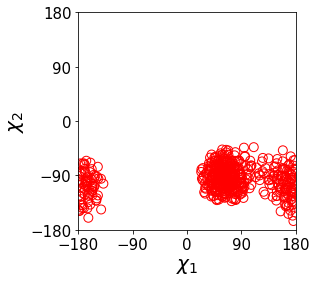

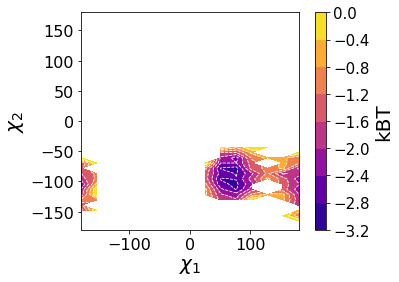

In [ ]:
#@title Analysis Plot chi1 vs chi2 of Trp8
#@markdown free energy plot (without reweighting on the biased CVs)
fes_nrw=True #@param {type:"boolean"}
%cd /content/test_MD/


traj = md.load_dcd('output_gpu_plm.dcd', top='reference.pdb')
Chivals=np.zeros((2,len(traj)))
for ind, tr in enumerate(traj):
  #print('step : ',ind)
  ta1,tb1=md.compute_chi1(tr);
  ta2,tb2=md.compute_chi2(tr);
  Chivals[0,ind]=tb1[0][6];
  Chivals[1,ind]=tb2[0][5];
  #Chival2[ind]=tb2[0][5];

Chivals=Chivals*(180/np.pi)
left=-180;
right=180;


plt.figure(1);
plt.gca().set_aspect('equal')
plt.scatter(Chivals[0,:], Chivals[1,:],s=80,facecolors='none',edgecolors='r')
plt.xlabel(r'$\chi_1$',fontsize=20);
plt.ylabel(r'$\chi_2$',fontsize=20);
plt.xlim([left,right]);
plt.ylim([left,right]);
plt.xticks([-180,-90,0,90,180],fontsize=15);
plt.yticks([-180,-90,0,90,180],fontsize=15);
plt.show();

if fes_nrw:
  numpy.seterr(divide = 'ignore')
  hist,xv,yv=np.histogram2d(Chivals[0,:],Chivals[1,:],bins=15)
  ln_hist=-np.log(hist)
  plt.figure(2)
  plt.gca().set_aspect('equal')
  plt.contourf(ln_hist.transpose(),extent=[xv[0],xv[-1],yv[0],yv[-1]],cmap=plt.cm.plasma)
  cbar=plt.colorbar()
  plt.contour(ln_hist.transpose(),extent=[xv[0],xv[-1],yv[0],yv[-1]],colors='white',linewidths=0.8)
  plt.xlabel(r'$\chi_1$',fontsize=20);
  plt.ylabel(r'$\chi_2$',fontsize=20);
  plt.xticks(fontsize=16);
  plt.yticks(fontsize=16);
  plt.xlim([left,right]);
  plt.ylim([left,right]);
  cbar.set_label('kBT',fontsize=20)
  cbar.ax.tick_params(labelsize=15)